In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers, preprocessing
import pathlib
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

In [4]:
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                 split = ["train", "validation"],
                                 shuffle_files = True,
                                 as_supervised = True,
                                 with_info = True)

In [10]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [72]:
def plot_examples(data, class_names):
    """
    Plots images from dataset with their class names and shape
    """
    
    plt.figure(figsize=(20, 15))
    for i in range(16):
        one_sample = data.take(1)
        plt.subplot(4,4, i+1)
        for image, label in one_sample:
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"{class_names[label]}  {image.shape}")

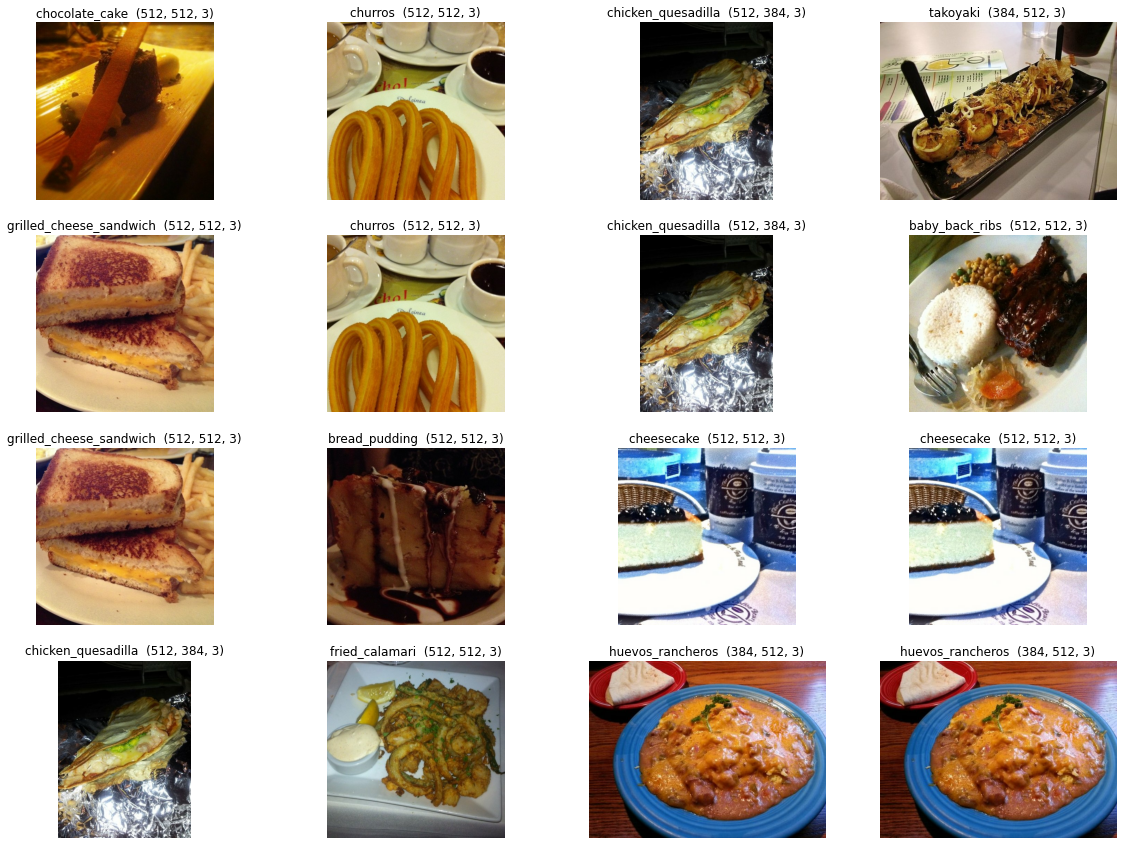

In [70]:
plot_examples(train_data, class_names)

In [77]:
def preprocess_image(image, label, img_shape = 224):
    """
    Converts image datatype to 'float32' and reshape images to 
    [img_shape, img_shape, color_channels]
    """
    
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label
    

In [79]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [80]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [82]:
import datetime

In [83]:
def create_tensorboard_callback(dir_name, experiment_name):
    
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    tesnorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    
    print(f"Saving Tensorboard to {log_dir}")
    return tesnorboard_callback

In [84]:
def create_model_checkpoint(dir_name, model_name, save_weights_only = True, monitor = "val_accuracy", save_best_only = True):
    
    path = dir_name + "/" + model_name + ".ckpt"
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(path,
                                                         monitor=monitor,
                                                         save_best_only=save_best_only,
                                                         save_weights_only=save_weights_only)
    return model_checkpoint

In [86]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


In [135]:
tf.keras.backend.clear_session()

In [136]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 


inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(len(class_names), kernel_initializer="he_normal")(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs, name='EfficientNetB0')

In [137]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [138]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
efficientnetb0 False
pooling_layer True
flatten True
dropout True
dense True
softmax_float32 True


In [139]:
model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                    

In [140]:
history_efficient_b0 = model.fit(train_data,
                                validation_data=test_data,
                                validation_steps=int(len(test_data)*0.15),
                                epochs = 3,
                                callbacks=[create_model_checkpoint('checkpoints', 'efficientB0_base')])

Epoch 1/3
2368/2368 [==============================] - 98s 37ms/step - loss: 1.9615 - accuracy: 0.5219 - val_loss: 1.2862 - val_accuracy: 0.6653
Epoch 2/3
2368/2368 [==============================] - 91s 38ms/step - loss: 1.4662 - accuracy: 0.6248 - val_loss: 1.1569 - val_accuracy: 0.6875
Epoch 3/3
2368/2368 [==============================] - 90s 38ms/step - loss: 1.3594 - accuracy: 0.6464 - val_loss: 1.1161 - val_accuracy: 0.7013


In [141]:
efficient_b0_base_performance = model.evaluate(test_data)
efficient_b0_base_performance

790/790 [==============================] - 28s 34ms/step - loss: 1.1239 - accuracy: 0.6990


[1.1238702535629272, 0.699009895324707]

In [154]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [144]:
base_model.trainable = True
for layer in model.layers[1].layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [152]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

In [149]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
flatten True
dropout True
dense True
softmax_float32 True


In [150]:
for layer in model.layers[1].layers:
    print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn False
block2a_expand_conv True
block2a_expand_bn False
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn False
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn False
block2b_expand_conv True
block2b_expand_bn False
block2b_expand_activation True
block2b_dwconv True
block2b_bn False
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn False
block2b_drop 

In [153]:
history_efficient_b0_fine_tuned = model.fit(train_data,
                                validation_data=test_data,
                                validation_steps=int(len(test_data)*0.15),
                                epochs = 3,
                                callbacks=[create_model_checkpoint('checkpoints', 'efficientB0_fine_tuned'),
                                          create_tensorboard_callback("logs_dir", "efficientB0_fine_tuned"),
                                          early_stopping,
                                          reduce_lr])

Saving Tensorboard to logs_dir/efficientB0_fine_tuned/20220127-194555
Epoch 1/3


C:\Users\patry\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 264s 107ms/step - loss: 1.0915 - accuracy: 0.7120 - val_loss: 0.8044 - val_accuracy: 0.7818 - lr: 1.0000e-04
Epoch 2/3
2368/2368 [==============================] - 249s 105ms/step - loss: 0.7661 - accuracy: 0.7905 - val_loss: 0.7297 - val_accuracy: 0.7974 - lr: 1.0000e-04
Epoch 3/3
2368/2368 [==============================] - 252s 106ms/step - loss: 0.5446 - accuracy: 0.8462 - val_loss: 0.7054 - val_accuracy: 0.8085 - lr: 1.0000e-04


In [155]:
history_efficient_b0_fine_tuned = model.fit(train_data,
                                validation_data=test_data,
                                validation_steps=int(len(test_data)*0.15),
                                initial_epoch=history_efficient_b0_fine_tuned.epoch[-1],
                                epochs = 50,
                                callbacks=[create_model_checkpoint('checkpoints', 'efficientB0_fine_tuned'),
                                          create_tensorboard_callback("logs_dir", "efficientB0_fine_tuned"),
                                          early_stopping,
                                          reduce_lr])

Saving Tensorboard to logs_dir/efficientB0_fine_tuned/20220127-200021
Epoch 3/50


C:\Users\patry\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 248s 105ms/step - loss: 0.3679 - accuracy: 0.8922 - val_loss: 0.7250 - val_accuracy: 0.8125 - lr: 1.0000e-04
Epoch 4/50
2368/2368 [==============================] - 249s 105ms/step - loss: 0.2434 - accuracy: 0.9260 - val_loss: 0.7592 - val_accuracy: 0.8120 - lr: 1.0000e-04
Epoch 5/50
2368/2368 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9473
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 249s 105ms/step - loss: 0.1701 - accuracy: 0.9473 - val_loss: 0.7876 - val_accuracy: 0.8149 - lr: 1.0000e-04
Epoch 6/50
2368/2368 [==============================] - 248s 105ms/step - loss: 0.0601 - accuracy: 0.9830 - val_loss: 0.8380 - val_accuracy: 0.8268 - lr: 2.0000e-05
Epoch 7/50
2367/2368 [============================>.] - ETA: 0s - loss: 0.0376 - accuracy: 0.9899
Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/

In [156]:
efficient_b0_tuned_performance = model.evaluate(test_data)
efficient_b0_tuned_performance

790/790 [==============================] - 28s 35ms/step - loss: 0.9114 - accuracy: 0.8170


[0.911419153213501, 0.8170297145843506]

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (img_shape, img_shape, 3).
  """

    img = tf.io.read_file(filename)

    img = tf.image.decode_jpeg(img)

    img = tf.image.resize(img, [img_shape, img_shape])
    if scale:
        return img/255.
    else:
        return img

In [273]:
one_sample = train_data.take(1)
for image, label in one_sample:
    #print(image[0].shape)
    #print(np.array(image[0]))
    print(model.predict(tf.expand_dims(np.array(image[0]), axis=0)))

[[2.61889814e-14 2.12404331e-17 7.42480743e-20 3.18476090e-25
  5.62815426e-18 4.82126784e-21 3.24365823e-20 3.56246140e-20
  3.82424629e-16 8.81717664e-20 1.89884714e-22 8.83045912e-23
  2.40685636e-17 5.13994353e-24 9.82147606e-17 3.95394514e-15
  2.71588159e-19 5.57595563e-15 5.54089787e-18 9.38583617e-20
  6.68359867e-18 9.53364172e-20 9.97614229e-17 1.36644679e-15
  4.24835372e-18 2.99989328e-20 5.89825520e-18 5.74952151e-19
  3.57747260e-18 7.29870159e-17 2.99989328e-20 7.29870159e-17
  3.18377052e-14 5.23812586e-15 9.57381323e-18 1.99835995e-20
  2.73143407e-20 2.31952270e-16 1.40474546e-13 1.04706564e-19
  8.24811330e-09 2.81813908e-20 3.12596103e-19 2.64341463e-17
  1.27558716e-18 1.58510601e-15 2.79033547e-21 2.00797902e-14
  3.84155490e-25 1.66117677e-15 2.75865044e-19 3.93500399e-21
  9.05337220e-13 2.56208524e-17 4.42022788e-14 8.55100565e-16
  5.96600075e-20 2.40685636e-17 5.89825520e-18 3.32756769e-19
  4.29714900e-20 2.90759640e-20 7.22336750e-08 1.47040351e-21
  2.8582

In [354]:
def pred_and_plot_images(model, data, class_names):
    
    plt.figure(figsize=(15, 20))
    for i in range(16):
        one_sample = data.take(1)
        plt.subplot(4,4, i+1)
        for image, label in one_sample:
            img = np.array(image[0]) / 255.
            pred = model.predict(tf.expand_dims(np.array(image[0]), axis=0))
            if len(pred[0]) > 1:
                prediction = class_names[pred.argmax()]
            else:
                prediction = class_names[int(tf.round(pred)[0][0])]
            if prediction == class_names[int(label[0])]:
                title_color = 'g'
            else:
                title_color = 'r'
                plt.xlabel(f"True labels: {class_names[int(label[0])]}")
            plt.imshow(img)
            plt.title(f"Prediction: {prediction}", c=title_color)
            

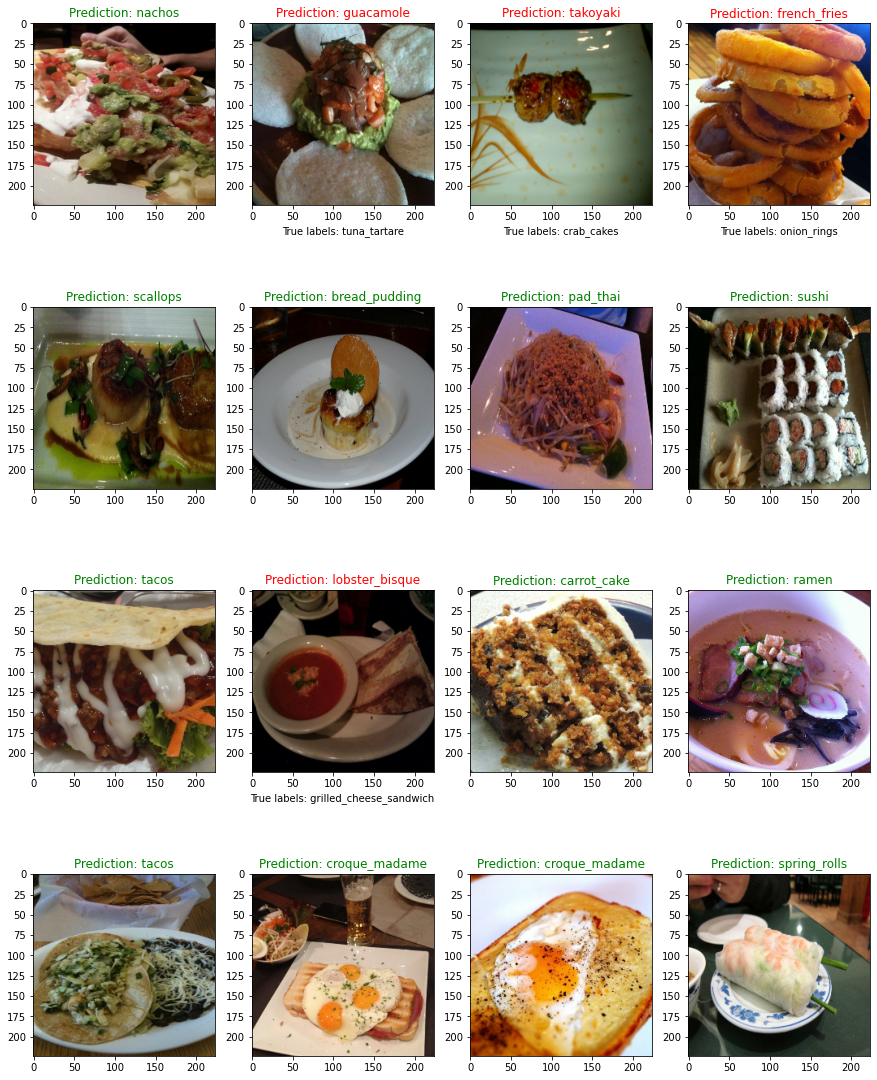

In [355]:
pred_and_plot_images(model, test_data, class_names)